In [1]:
def occupancy(floor):
    
    # Import necessary packages
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import math
    
    # Create a blank data frame to store KPIs
    kpi = pd.DataFrame(0,
                       index = floor.floor.unique(), 
                       columns = ['tArr_wkdy','tDpt_wkdy','sOcc_wkdy','tArr_wknd','tDpt_wknd','sOcc_wknd'])
    
    # Create a data frame to populate with building-level occupancy for weekdays
    bdg_wkdy = pd.DataFrame(0, 
                            index=range(0,23), 
                            columns = ['25th percentile','Median','75th percentile'])
    
    # Create a data frame to populate with building-level occupancy for weekdays
    bdg_wknd = pd.DataFrame(0, 
                            index=range(0,23), 
                            columns = ['25th percentile','Median','75th percentile'])
    
    # Loop through each floor 
    for j in floor.floor.unique():
        
        # Assign single floor to new data frame
        df = floor.loc[floor['floor']==j]

        # Specify desired quantiles
        quantiles = [.25,.5,.75]
        
        # Create blank list to store each quantile on workdays and populate
        line = []
        for i in quantiles:
            temp = df.loc[df['workday'] == True].groupby(['hour'])['wifi counts'].quantile(i)
            temp = round((temp-temp.min())/1.2)
            line.append(temp)
        
        # Turn list into data frame, rename columns, and add to building-level data frame for workdays
        occ_wkdy = pd.concat(line, axis=1)
        occ_wkdy.columns = ['25th percentile','Median','75th percentile']
        for col in occ_wkdy:
                occ_wkdy.loc[occ_wkdy[col]<4,col] = 0 #If occupancy count is less than four per floor, count as no occupancy.
        bdg_wkdy = bdg_wkdy + occ_wkdy
        
        # Create blank list to store each quantile on weekends and populate
        line = []
        for i in quantiles:
            temp = df.loc[df['workday'] == False].groupby(['hour'])['wifi counts'].quantile(i)
            temp = round((temp-temp.min())/1.2) #Assuming 1.2 devices per person
            line.append(temp)
        
        # Turn list into data frame, rename columns, and add to building-level data frame for weekends
        occ_wknd = pd.concat(line, axis=1)
        occ_wknd.columns = ['25th percentile','Median','75th percentile']
        for col in occ_wknd:
                occ_wknd.loc[occ_wknd[col]<4,col] = 0 #If occupancy count is less than four per floor, count as no occupancy.
        bdg_wknd = bdg_wknd + occ_wknd

        # Determine KPIs and store them in data frame for function to return
        if occ_wkdy.iloc[:,2].max() == 0:
                kpi.iloc[j-1,0] = np.nan # no arrivals for Wkdy
                kpi.iloc[j-1,1] = np.nan # no departures for Wkdy
        else:
                kpi.iloc[j-1,0] = max((np.where(occ_wkdy.iloc[:,2]/occ_wkdy.iloc[:,2].max() > 0.1)[0][0]-1),0) # tArr_Wkdy
                kpi.iloc[j-1,1] = (np.where(occ_wkdy.iloc[:,2]/occ_wkdy.iloc[:,2].max() > 0.1)[0][-1]-1) # tDpt_wkdy
        kpi.iloc[j-1,2] = (occ_wkdy.iloc[:,2].max()) #sOcc_wkdy

        if occ_wknd.iloc[:,2].max() == 0:
                kpi.iloc[j-1,3] = np.nan # No arrivals for Wknd
                kpi.iloc[j-1,4] = np.nan # No departure for Wknd
        else:
                kpi.iloc[j-1,3] = max((np.where(occ_wknd.iloc[:,2]/occ_wknd.iloc[:,2].max() > 0.1)[0][0]-1),0) # tArr_wknd
                kpi.iloc[j-1,4] = (np.where(occ_wknd.iloc[:,2]/occ_wknd.iloc[:,2].max() > 0.1)[0][-1]-1) # tDpt_wknd
        kpi.iloc[j-1,5] = (occ_wknd.iloc[:,2].max()) # sOcc_wknd

    #----Building-level quantile plots----#
    fig = plt.figure(figsize=(8, 4), dpi=600)

    # Weekday subplot
    ax = plt.subplot(1,2,1)
    ax.plot(bdg_wkdy.iloc[:,0],
            label = '25th percentile',
            linewidth=2)
    ax.plot(bdg_wkdy.iloc[:,1],
            label = 'Median',
            linewidth=2)
    ax.plot(bdg_wkdy.iloc[:,2],
            label = '75th percentile',
            linewidth=2)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Subplot formatting
    plt.axis([0, 24, 0, math.ceil(bdg_wkdy.iloc[:,2].max()/50)*50])
    ax.set_xticks([0,6,12,18,24])
    ax.set_xticklabels(['00:00','06:00','12:00','18:00','23:45'])
    plt.xlabel('Time of day', fontsize=14)
    plt.ylabel('Estimated occupancy (persons)', fontsize=14)
    ax.fill_between(bdg_wkdy.index, bdg_wkdy.iloc[:,0],bdg_wkdy.iloc[:,2], color='grey',alpha=0.4)

    # Weekend subplot
    ax = plt.subplot(1,2,2)
    ax.plot(bdg_wknd.iloc[:,0],
            label = '25th percentile',
            linewidth=2)
    ax.plot(bdg_wknd.iloc[:,1],
            label = 'Median',
            linewidth=2)
    ax.plot(bdg_wknd.iloc[:,2],
            label = '75th percentile',
            linewidth=2)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Subplot formatting
    plt.axis([0, 24, 0, math.ceil(bdg_wknd.iloc[:,2].max()/50)*50])
    ax.set_xticks([0,6,12,18,24])
    ax.set_xticklabels(['00:00','06:00','12:00','18:00','23:45'])
    plt.xlabel('Time of day', fontsize=14)
    plt.ylabel('Estimated occupancy (persons)', fontsize=14)
    ax.fill_between(bdg_wknd.index, bdg_wknd.iloc[:,0],bdg_wknd.iloc[:,2], color='grey',alpha=0.4)
    
    # Output figure in console
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3,prop={"size":12})
    plt.tight_layout()
    fig.savefig(output_path + r'\percentile_occ.png',dpi=600,bbox_inches='tight')

    #----Floor-level occupancy plots----#
    df = floor

    # Upper quantile at the floor level for the weekday and weekend for plot
    temp = df.loc[df['workday'] == True].groupby(['floor','hour'])['wifi counts'].quantile(0.75).unstack(level='hour').T
    occ_wkdy_floor = round((temp-temp.min())/1.2)
    for col in occ_wkdy_floor.columns:
            occ_wkdy_floor.loc[occ_wkdy_floor[col]<4,col] = 0 #If occupancy count is less than four per floor, count as no occupancy.

    temp = df.loc[df['workday'] == False].groupby(['floor','hour'])['wifi counts'].quantile(0.75).unstack(level='hour').T
    occ_wknd_floor = round((temp-temp.min())/1.2)
    for col in occ_wknd_floor.columns:
            occ_wknd_floor.loc[occ_wknd_floor[col]<4,col] = 0 #If occupancy count is less than four per floor, count as no occupancy.

    fig = plt.figure(figsize=(8, 4), dpi=600)

    # Weekday subplot
    x = occ_wkdy_floor.index
    y = occ_wkdy_floor.T.rename_axis('ID').values
    ax = plt.subplot(1,2,1)
    ax.stackplot(x,y,
                 labels = ["Floor " + str(floor_num) for floor_num in floor.floor.unique()])
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Subplot formatting
    plt.axis([0, 24, 0, math.ceil(bdg_wkdy.iloc[:,2].max()/50)*50])
    ax.set_xticks([0,6,12,18,24])
    ax.set_xticklabels(['00:00','06:00','12:00','18:00','23:45'])
    plt.xlabel('Time of day', fontsize=13)
    plt.ylabel('Estimated occupancy (persons)', fontsize=13)

    # Weekend subplot
    x = occ_wknd_floor.index
    y = occ_wknd_floor.T.rename_axis('ID').values
    ax = plt.subplot(1,2,2)
    ax.stackplot(x,y,
                 labels = ["Floor " + str(floor_num) for floor_num in floor.floor.unique()])
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Subplot formatting
    plt.axis([0, 24, 0, math.ceil(bdg_wknd.iloc[:,2].max()/50)*50])
    ax.set_xticks([0,6,12,18,24])
    ax.set_xticklabels(['00:00','06:00','12:00','18:00','23:45'])
    plt.xlabel('Time of day', fontsize=13)
    plt.ylabel('Estimated occupancy (persons)', fontsize=13)
    
    # Output figure in console
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.97, 1), ncol=((len(kpi.index)//15)+1),prop={"size":10})
    plt.tight_layout()
    fig.savefig(output_path + r'\floor_level_occ.png',dpi=600,bbox_inches='tight')
    
    return kpi

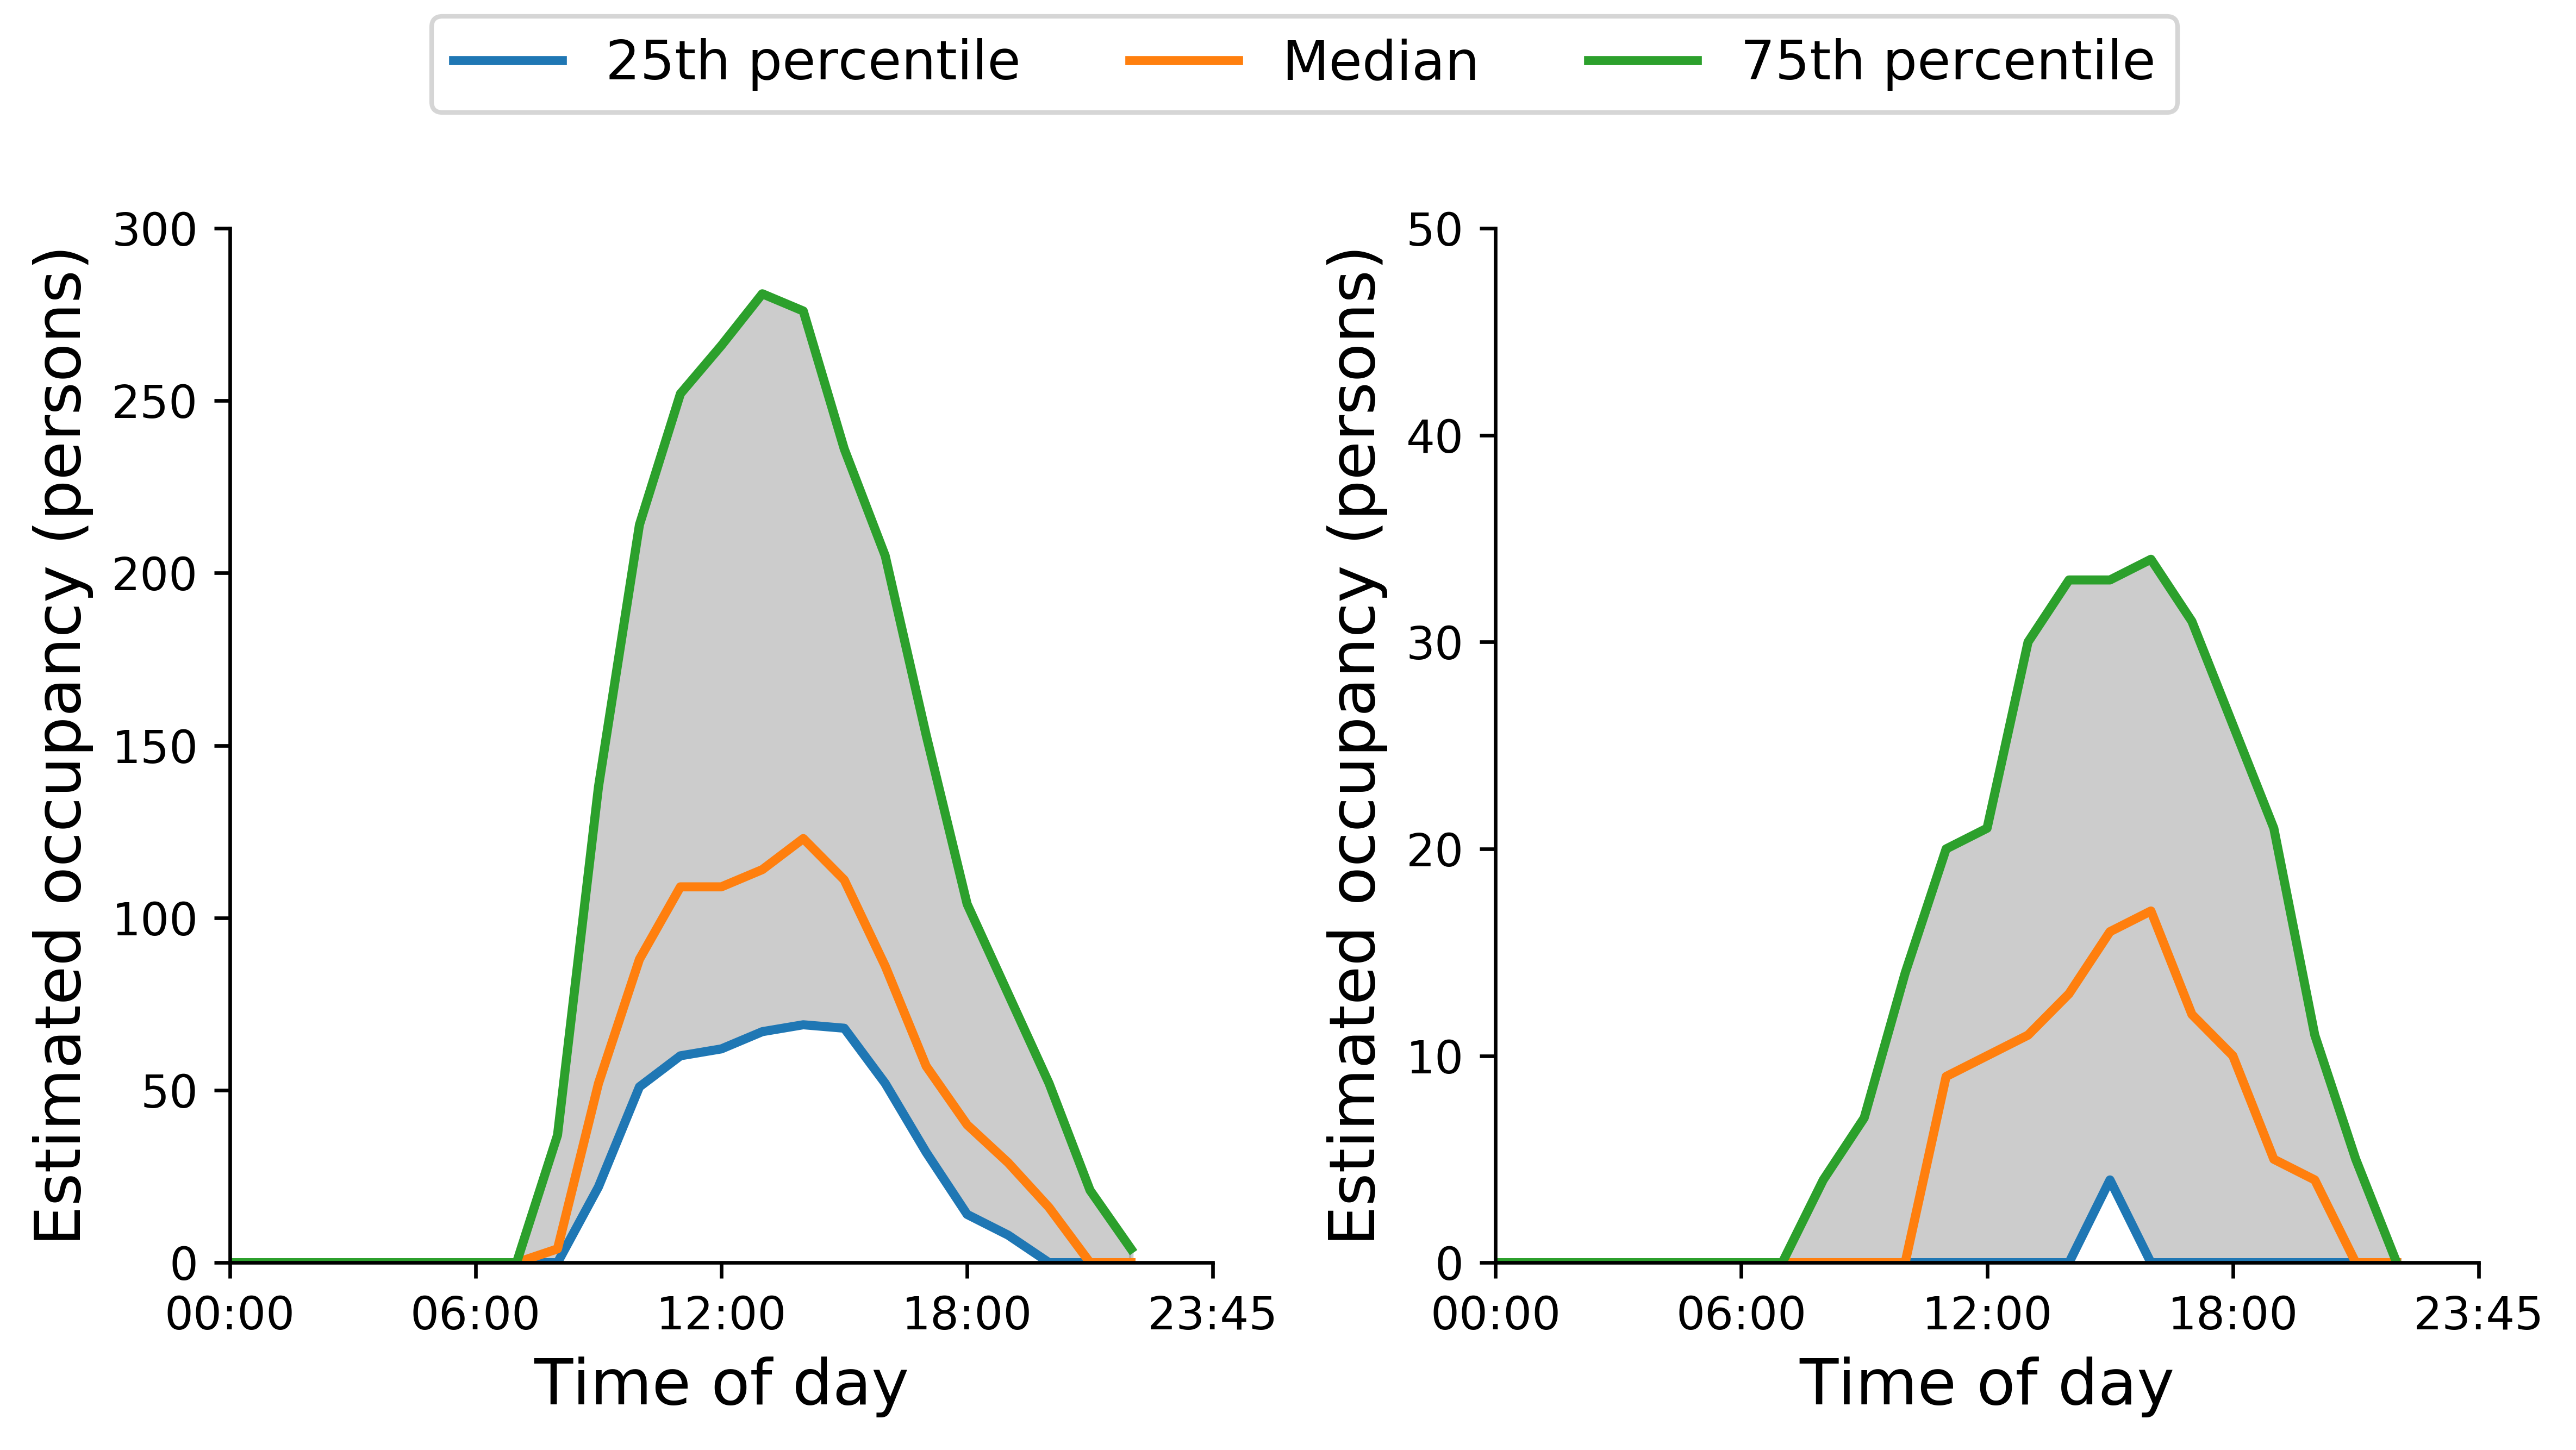

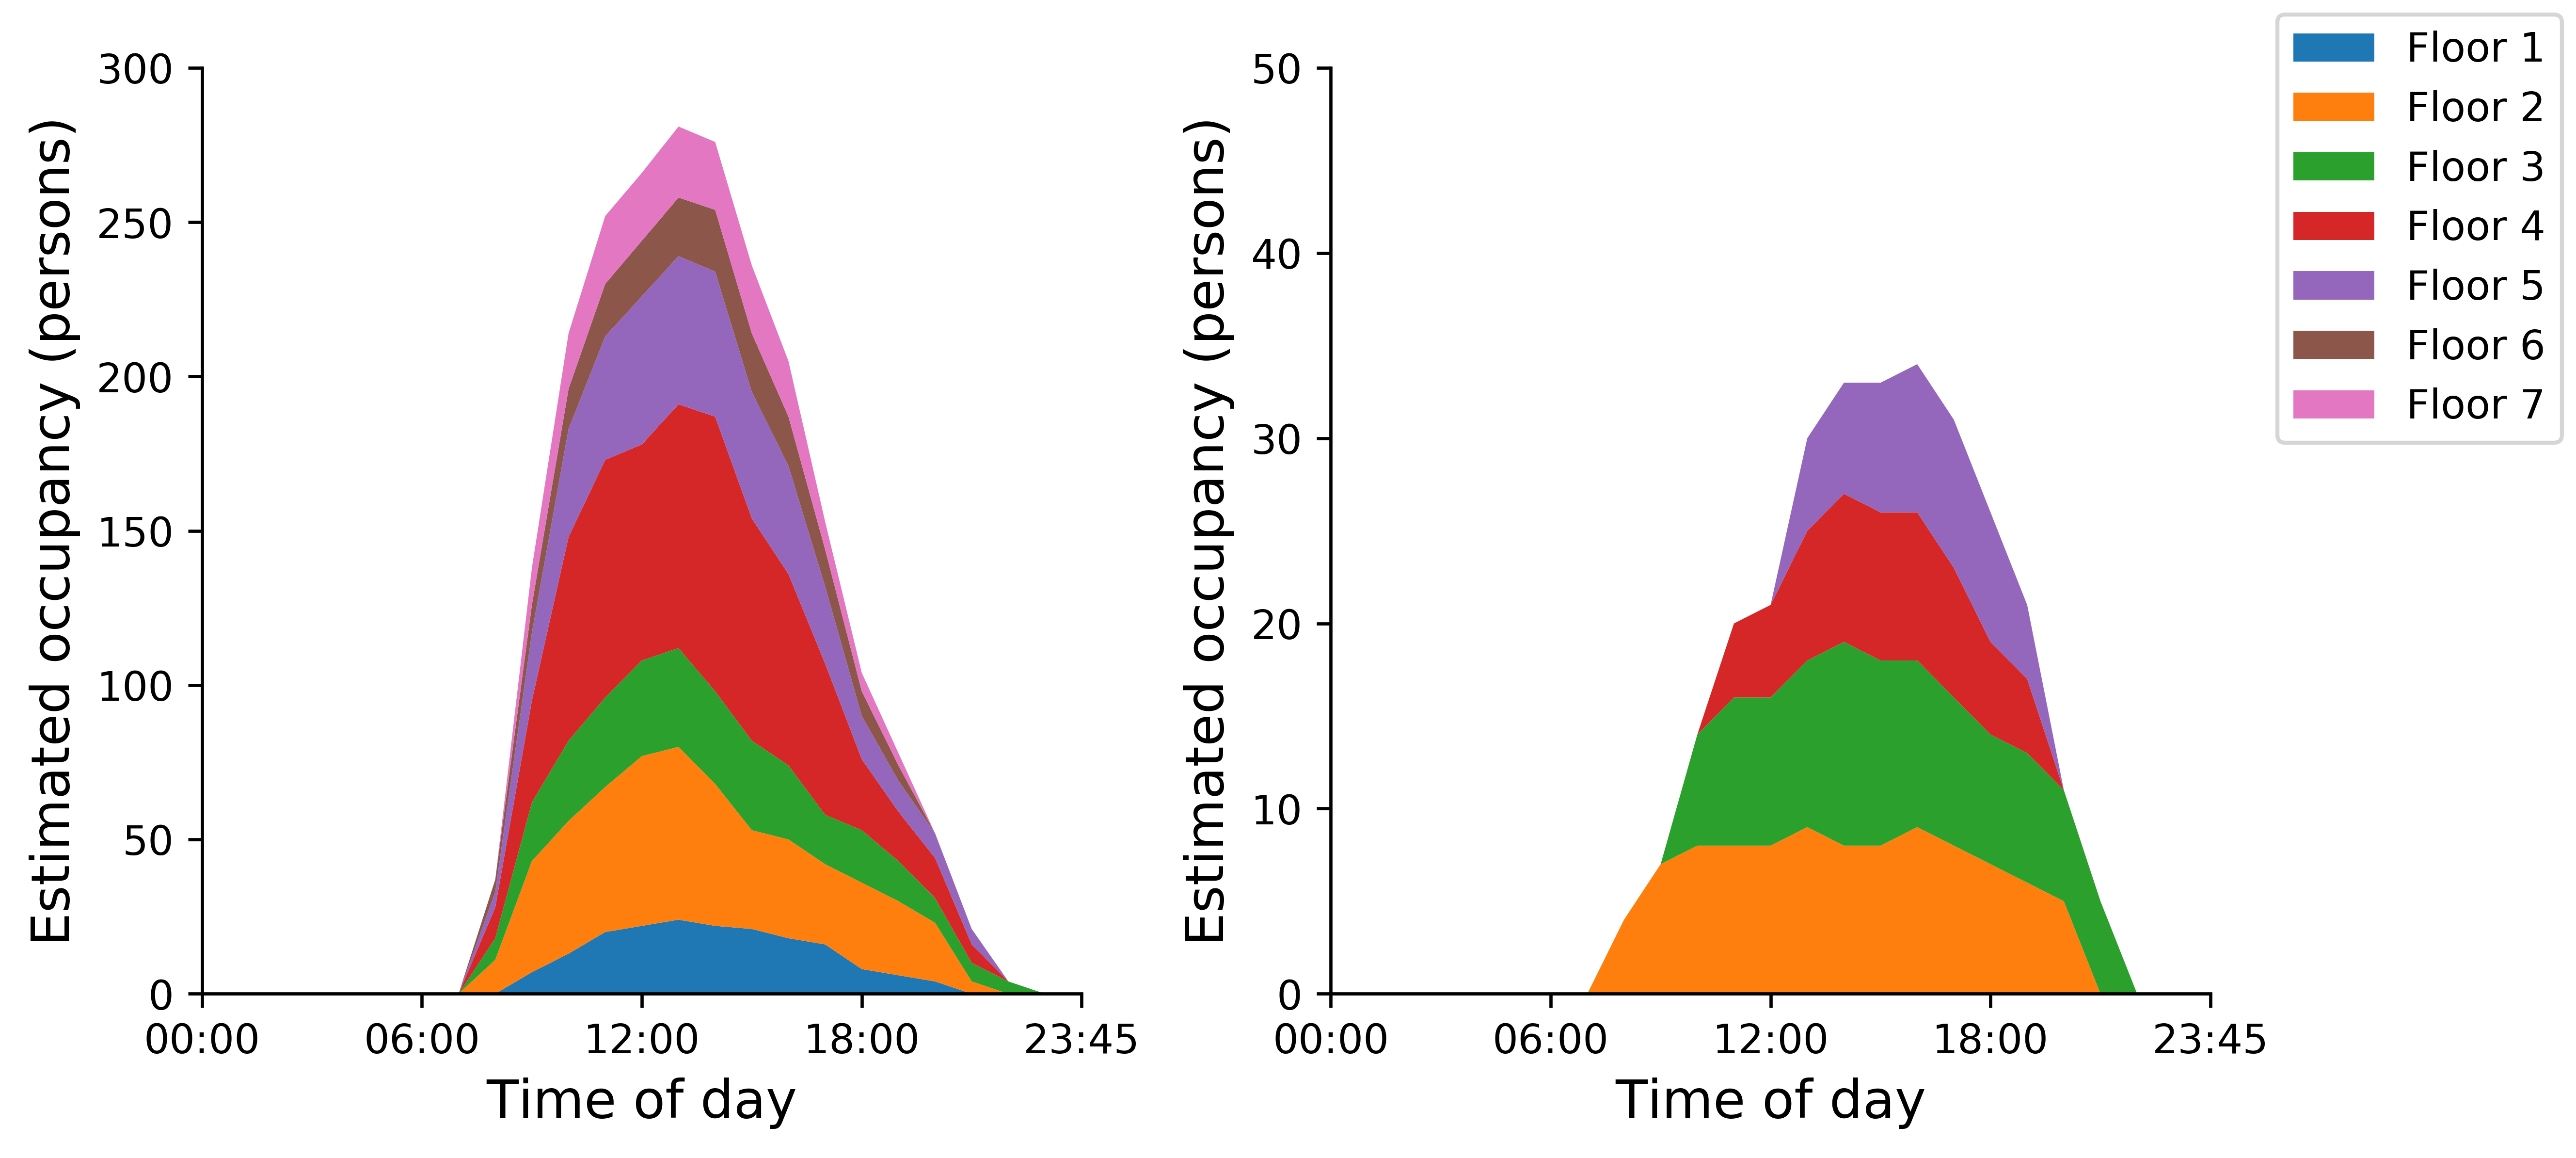

In [2]:
# Import necessary packages
import pandas as pd
import os

# Find current file directory
pwd = os.getcwd()
# Change file directory to where Wi-Fi data is located
path = pwd.replace('occupancy','occupancy\\occupancy data\\wifi')

#Specify current directory and input/output paths
path = os.getcwd()
wifi_input_path = path + r'\sample data\wifi'
output_path = output_path = path + r'\output'

#Read Wi-Fi data files
wifi_files = os.listdir(wifi_input_path)
wifi_files_csv = [f for f in wifi_files if f[-3:] == 'csv']

floor_count = 0
floor = []
for f in wifi_files_csv:
    temp = pd.read_csv(wifi_input_path + '\\' + f)
    temp[temp.columns[0]] = pd.to_datetime(temp[temp.columns[0]])#Convert timeframe column time to datetime object
    temp = temp.set_index(temp[temp.columns[0]])# Set the index to the timestamp

    floor_count += 1
    temp['floor'] = floor_count
    temp['hour'] = temp.index.hour
    temp['weekday'] = temp.index.weekday
    temp['workday'] = temp.weekday.isin(range(0,5)).values

    ind = temp['wifi counts'].rolling(96).std() > 0.001 # Disgard stagnant values (data acquisition error)
    temp = temp.iloc[ind.values]

    floor.append(temp) # Store the data for this floor in the list

# Concatenate the list by columns into a single dataframe   
floor = pd.concat(floor, axis=0)

# Run local function occupancy to generate KPIs and visualizations
kpi = occupancy(floor)

writer = pd.ExcelWriter(output_path + r'\arrive_depart_maxOcc.xlsx', engine='xlsxwriter')
kpi.to_excel(writer, sheet_name='KPIs')
writer.save()
